In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna

import warnings
warnings.filterwarnings("ignore")


#### a) In a given dataset 'Hydro.xlsx‘ one can find realized production of Iron Gate hydro power plant which is located on the Serbian and Romanian border (Wiki) and river inflow just before the power generators on a daily resolution. Build a linear numerical model which describes the relationship between river inflow and electricity production.

#### y = f (x) = k ∗ x + n,

#### where x – is river flow [m3/s]and y – realized daily energy production [MWh/day] Based on your model determine what will be daily energy production at river inflow of 4000 [m3/s]and 11000 [m3/s]?

In [6]:
df = pd.read_excel('../data/Hydro.xlsx', parse_dates=['Date'], index_col='Date')
df.sort_index(inplace=True)
df.tail()

,River Flow [m^3/s],Production [MWh/daily]
Date,,
2017-12-27,7700.0,NaN
2017-12-28,7600.0,NaN
2017-12-29,7450.0,NaN
2017-12-30,7300.0,NaN
2017-12-31,7200.0,NaN


In [7]:
df.dtypes

River Flow [m^3/s]        float64
Production [MWh/daily]    float64
dtype: object

In [8]:
df.describe()

,River Flow [m^3/s],Production [MWh/daily]
count,1054.000000,819.000000
mean,4837.251661,13979.007326
std,1925.314435,4540.674561
min,2150.000000,5271.000000
25%,3164.892339,9976.000000
50%,4550.000000,13660.000000
75%,6200.000000,17705.000000
max,11900.000000,25020.000000


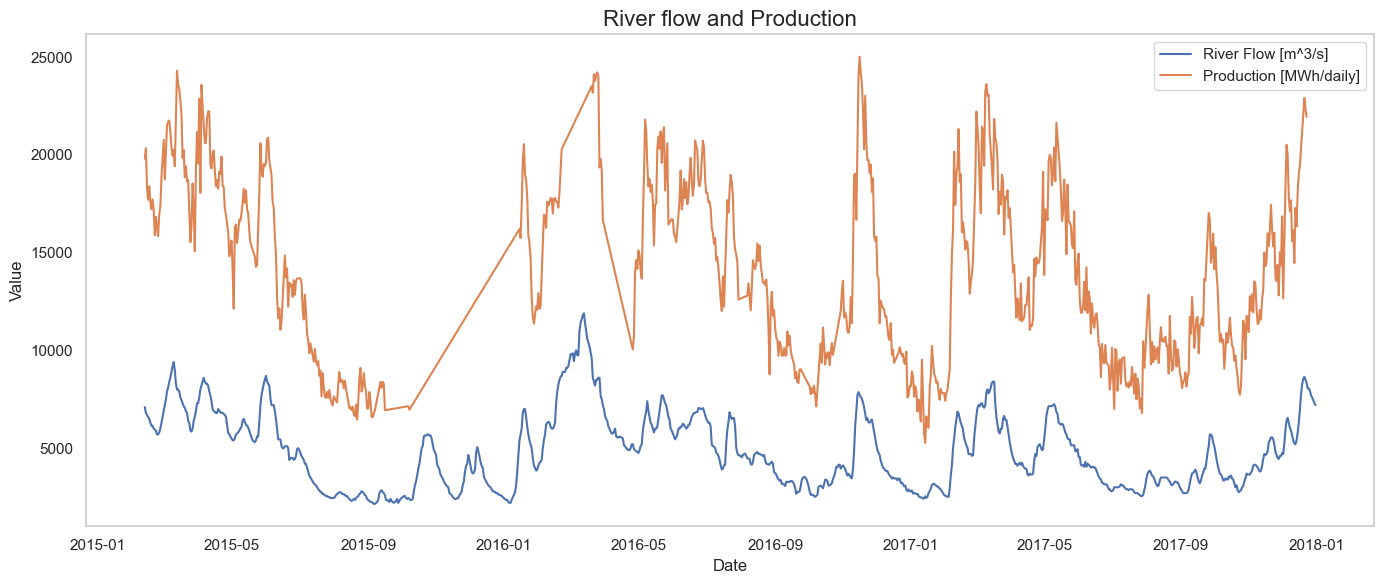

In [12]:
sns.set_theme(style='whitegrid')

plt.figure(figsize=(14, 6))
sns.lineplot(data=df, x='Date', y='River Flow [m^3/s]', label='River Flow [m^3/s]')
sns.lineplot(data=df, x='Date', y='Production [MWh/daily]', label='Production [MWh/daily]')

plt.title('River flow and Production', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [13]:
df.isna().sum()

River Flow [m^3/s]          0
Production [MWh/daily]    235
dtype: int64

Before: 1054 rows
After clean: 819 rows


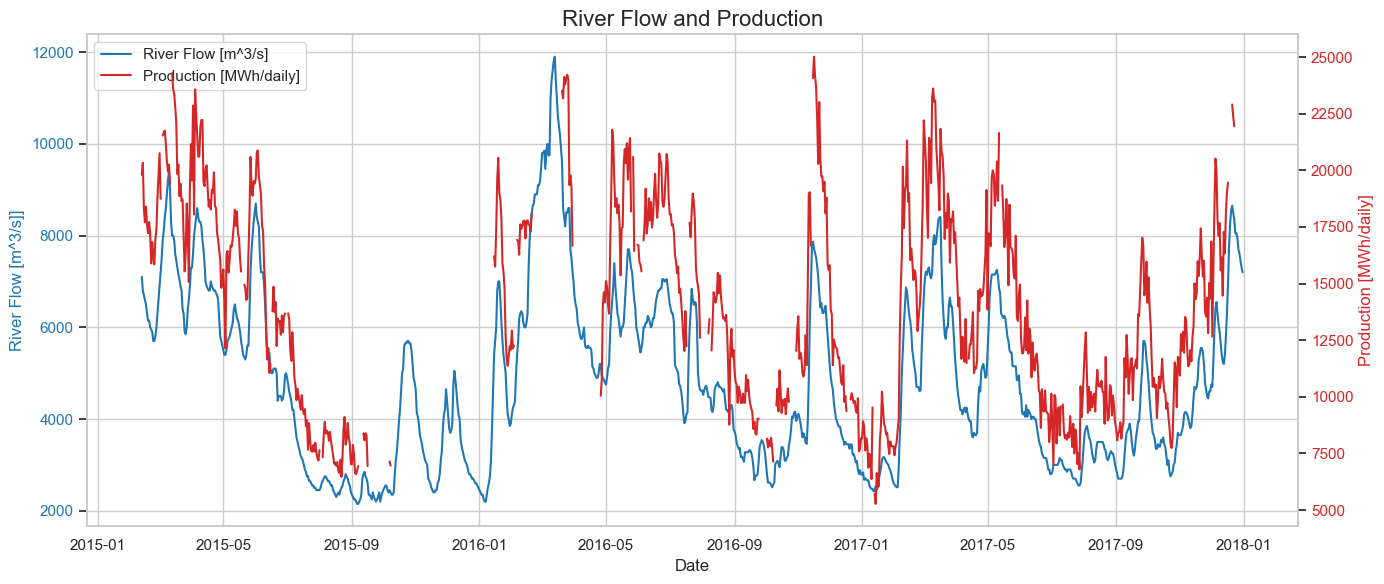

In [14]:
df_plot = df.copy()
print(f"Before: {len(df)} rows")
print(f"After clean: {len(df.dropna(axis=0, how='any'))} rows")

df_plot["Date"] = pd.to_datetime(df_plot.index)

fig, ax1 = plt.subplots(figsize=(14, 6))

# leva os
ax1.plot(df_plot["Date"], df_plot["River Flow [m^3/s]"], label="River Flow [m^3/s]", color="tab:blue")
ax1.set_xlabel("Date")
ax1.set_ylabel("River Flow [m^3/s]]", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")

# desna os
ax2 = ax1.twinx()
ax2.plot(df_plot["Date"], df_plot["Production [MWh/daily]"], label="Production [MWh/daily]", color="tab:red")
ax2.set_ylabel("Production [MWh/daily]", color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

# skupna legenda
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("River Flow and Production", fontsize=16)

fig.tight_layout()
plt.grid(False)
plt.show()

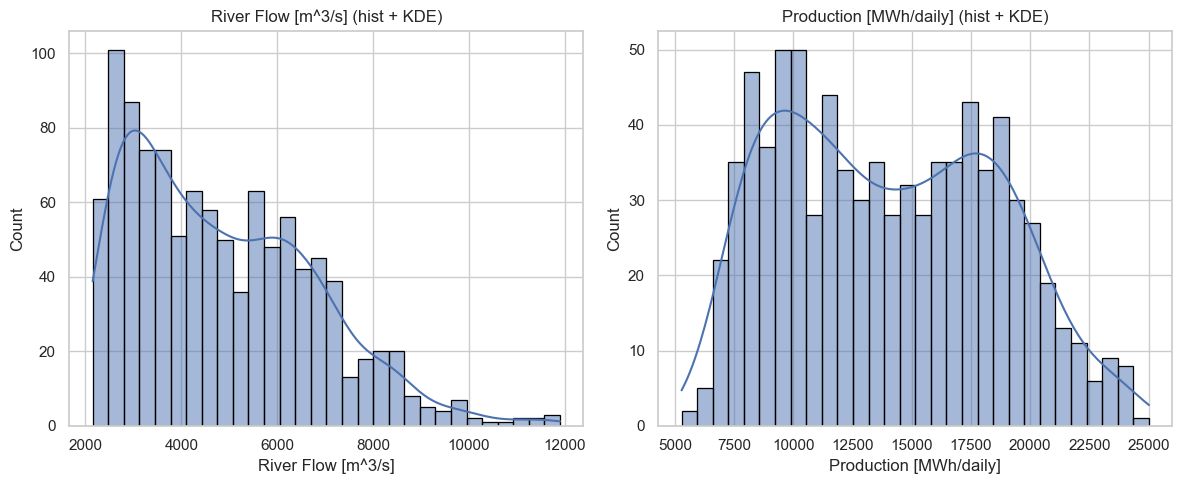

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='River Flow [m^3/s]', bins=30, kde=True, edgecolor='black')
plt.title('River Flow [m^3/s] (hist + KDE)')

plt.subplot(1, 2, 2)
sns.histplot(data=df, x='Production [MWh/daily]', bins=30, kde=True, edgecolor='black')
plt.title('Production [MWh/daily] (hist + KDE)')

plt.tight_layout()
plt.show()

## Hand made Linear Regression - We will Compare with scikit-learn Linear Reg

In [17]:
class LinReg(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(1))
        self.b = torch.nn.Parameter(torch.randn(1))

    def forward(self, x):
        return self.w * x + self.b

In [18]:
def linear_regression(
        df,
        lr=0.01,
        l2=1e-4,
        epochs=1000,
        scheduler_factor=0.5,
        scheduler_patience=15,
        early_stopping_patience=30,
        min_delta=1e-5,
        scaler_type="standard",
        beta1=0.9,
        beta2=0.999,
        plot=False,
        model=LinReg
):
    df_tmp = df.copy()
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    best_val_loss = float('inf')
    es_counter = 0
    best_model_state = None

    # podatki
    y = df_tmp[["Production [MWh/daily]"]].values.astype(np.float32)
    X = df_tmp[["River Flow [m^3/s]"]].values.astype(np.float32)

    # skaliranje
    if scaler_type == "standard":
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()
    elif scaler_type == "minmax":
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
    else:
        scaler_x = None
        scaler_y = None

    if scaler_x is not None:
        X_scaled = scaler_x.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y)
    else:
        X_scaled = X
        y_scaled = y

    # parametri skaliranja
    scaler_params = {}
    if scaler_x is not None:
        if scaler_type == "standard":
            scaler_params = {
                "mean_x": scaler_x.mean_,
                "std_x": scaler_x.scale_,
                "mean_y": scaler_y.mean_,
                "std_y": scaler_y.scale_,
            }
        elif scaler_type == "minmax":
            scaler_params = {
                "min_x": scaler_x.data_min_,
                "max_x": scaler_x.data_max_,
                "min_y": scaler_y.data_min_,
                "max_y": scaler_y.data_max_,
            }

    # razdelitev
    split_idx = int(len(y) * 0.8)
    X_train = torch.tensor(X_scaled[:split_idx], dtype=torch.float32)
    X_test = torch.tensor(X_scaled[split_idx:], dtype=torch.float32)
    y_train = torch.tensor(y_scaled[:split_idx], dtype=torch.float32)
    y_test = torch.tensor(y_scaled[split_idx:], dtype=torch.float32)

    model = model()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=l2, betas=(beta1, beta2))
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, min_lr=1e-9)

    losses, lr_values = [], []

    for epoch in range(epochs):
        model.train()
        y_hat = model(X_train)
        loss = loss_fn(y_train, y_hat)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        lr_values.append(optimizer.param_groups[0]['lr'])

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test)
            val_loss = loss_fn(y_test, val_pred).item()
            if val_loss + min_delta < best_val_loss:
                best_val_loss = val_loss
                es_counter = 0
                best_model_state = model.state_dict()
            else:
                es_counter += 1

            if es_counter >= early_stopping_patience:
                #print(f"Zgodnja ustavitev pri epohi {epoch}")
                break
            scheduler.step(val_loss)

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(14, 5))
        axs[0].plot(losses)
        axs[0].set_title(f"Loss – {scaler_type}")
        axs[0].set_xlabel("Epoch")
        axs[0].set_ylabel("Loss")
        axs[1].plot(lr_values)
        axs[1].set_title("Learning Rate")
        axs[1].set_xlabel("Epoch")
        axs[1].set_ylabel("LR")
        plt.tight_layout()
        plt.show()

    model.eval()
    with torch.no_grad():
        y_hat = model(X_test).numpy()
        y_true = y_test.numpy()

    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_hat)

    if scaler_x is not None:
        y_pred_orig = scaler_y.inverse_transform(y_hat)
        y_true_orig = scaler_y.inverse_transform(y_true)
    else:
        y_pred_orig = y_hat
        y_true_orig = y_true

    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(y_true_orig, label='Original y', linewidth=2)
        plt.plot(y_pred_orig, label='Prediction', linestyle='--')
        plt.title(f'Prediction vs. original (scaler: {scaler_type})')
        plt.xlabel('Time idx')
        plt.ylabel('Production [MWh/daily]')
        plt.legend()
        plt.tight_layout()
        plt.show()

    result_df = pd.DataFrame({
        "scaler": [scaler_type],
        "lr": [lr],
        "l2": [l2],
        "epochs": [epochs],
        "scheduler_factor": [scheduler_factor],
        "scheduler_patience": [scheduler_patience],
        "early_stopping_patience": [early_stopping_patience],
        "min_delta": [min_delta],
        "mse": [mse],
        "rmse": [rmse],
        "r2": [r2],
        **scaler_params
    })

    return result_df, model

In [139]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    l2 = trial.suggest_float("l2", 1e-8, 1e-3, log=True)
    beta1 = trial.suggest_float("beta1", 0.85, 0.95)
    beta2 = trial.suggest_float("beta2", 0.98, 0.9999)
    scaler_type = trial.suggest_categorical("scaler_type", ["standard", "minmax", "robust"])
    factor = trial.suggest_float("scheduler_factor", 0.1, 0.7)
    scheduler_patience = trial.suggest_int("scheduler_patience", 3, 15)
    early_stop = trial.suggest_int("early_stopping_patience", 10, 50)
    min_delta = trial.suggest_float("min_delta", 1e-6, 1e-2, log=True)

    result, _ = linear_regression(
        df=df.dropna(),
        lr=lr,
        l2=l2,
        beta1=beta1,
        beta2=beta2,
        scaler_type=scaler_type,
        epochs=5000,
        scheduler_factor=factor,
        scheduler_patience=scheduler_patience,
        early_stopping_patience=early_stop,
        min_delta=min_delta,
        plot=False,
        model=LinReg,
    )

    mse = result["mse"].values[0]
    r2 = result["r2"].values[0]
    return mse, -r2

In [142]:
study = optuna.create_study(directions=["minimize", "maximize"])
study.optimize(objective, n_trials=300)

best = min(study.best_trials, key=lambda t: t.values[0])  # t.values[0] = MSE
mse = best.values[0]
r2 = -best.values[1]  # obrnemo nazaj

print(f"Najboljši trial z najmanjšim MSE:")
print(f"MSE: {mse:.6f}, R²: {r2:.4f}")
print("Parametri:", best.params)

[I 2025-04-13 15:34:02,378] A new study created in memory with name: no-name-7a7c8aee-4928-446f-bf3d-a3c3544b7cfc
[I 2025-04-13 15:34:02,451] Trial 0 finished with values: [0.02497328817844391, -0.11743307113647461] and parameters: {'lr': 3.498879700471973e-05, 'l2': 0.02194457434692211, 'beta1': 0.9083547726443698, 'beta2': 0.9693480543971835, 'scheduler_factor': 0.8571453246470551, 'scheduler_patience': 26, 'early_stopping_patience': 63, 'min_delta': 0.0006733523276076772}.
[I 2025-04-13 15:34:02,480] Trial 1 finished with values: [0.011782154440879822, -0.5836135149002075] and parameters: {'lr': 0.0005130935123128422, 'l2': 0.049560720395170905, 'beta1': 0.9538092296036338, 'beta2': 0.9269313977598572, 'scheduler_factor': 0.5528764633412137, 'scheduler_patience': 47, 'early_stopping_patience': 51, 'min_delta': 5.5223455330792516e-05}.
[I 2025-04-13 15:34:02,931] Trial 2 finished with values: [0.014438587240874767, -0.4897339940071106] and parameters: {'lr': 1.2673157226203496e-05, '

Najboljši trial z najmanjšim MSE:
MSE: 0.002295, R²: 0.9189
Parametri: {'lr': 0.09387283037705745, 'l2': 2.957440695055275e-07, 'beta1': 0.9567150977837842, 'beta2': 0.9331176745635866, 'scheduler_factor': 0.8621453872028566, 'scheduler_patience': 48, 'early_stopping_patience': 67, 'min_delta': 7.261199815661029e-09}


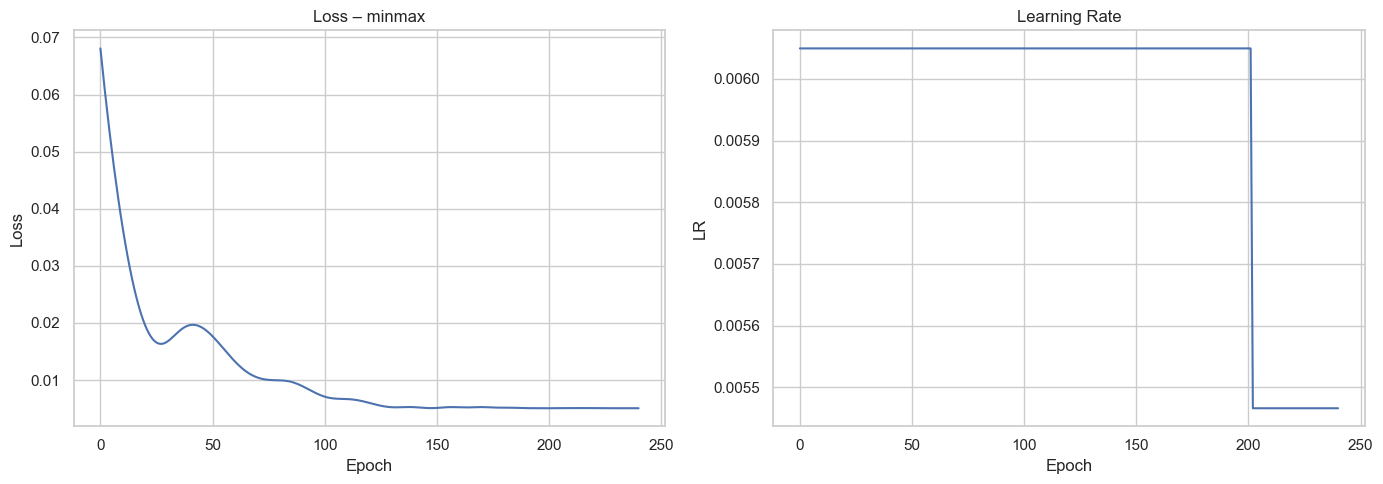

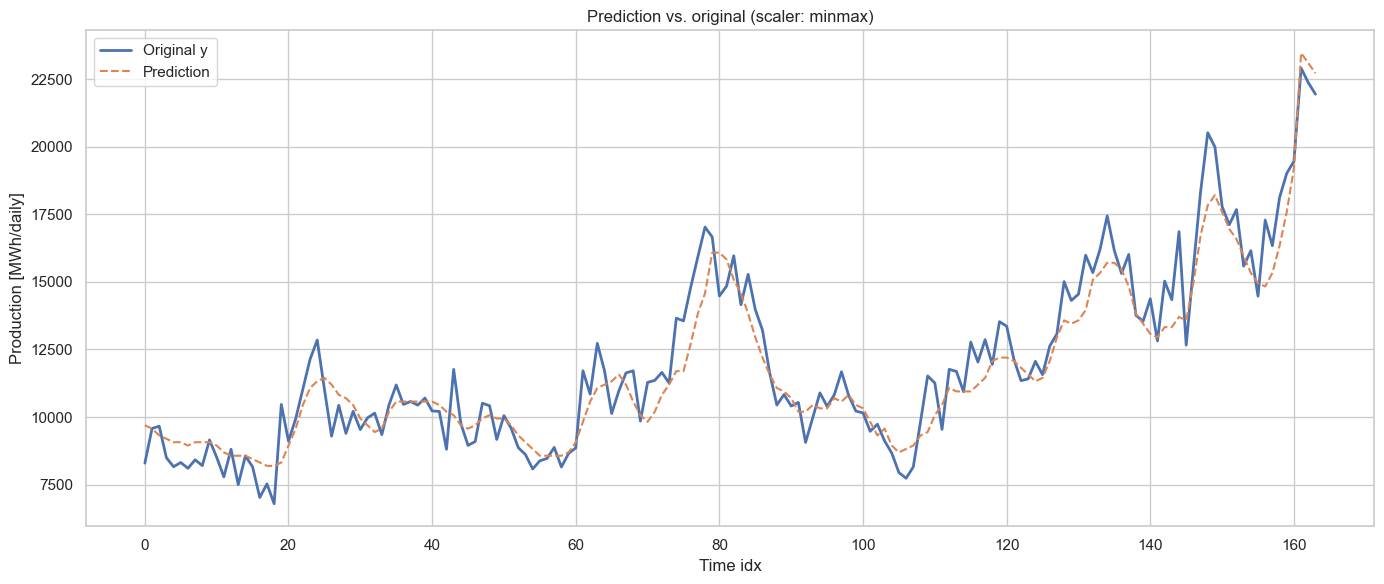

                                0
scaler                     minmax
lr                       0.006049
l2                       0.002332
epochs                       5000
scheduler_factor         0.903555
scheduler_patience             46
early_stopping_patience        86
min_delta                     0.0
mse                       0.00258
rmse                     0.050798
r2                       0.908808
min_x                      2150.0
max_x                      9600.0
min_y                      5271.0
max_y                     25020.0
r2: 0    0.908808
Name: r2, dtype: float64
mse: 0    0.00258
Name: mse, dtype: float64
rmse: 0    0.050798
Name: rmse, dtype: float64



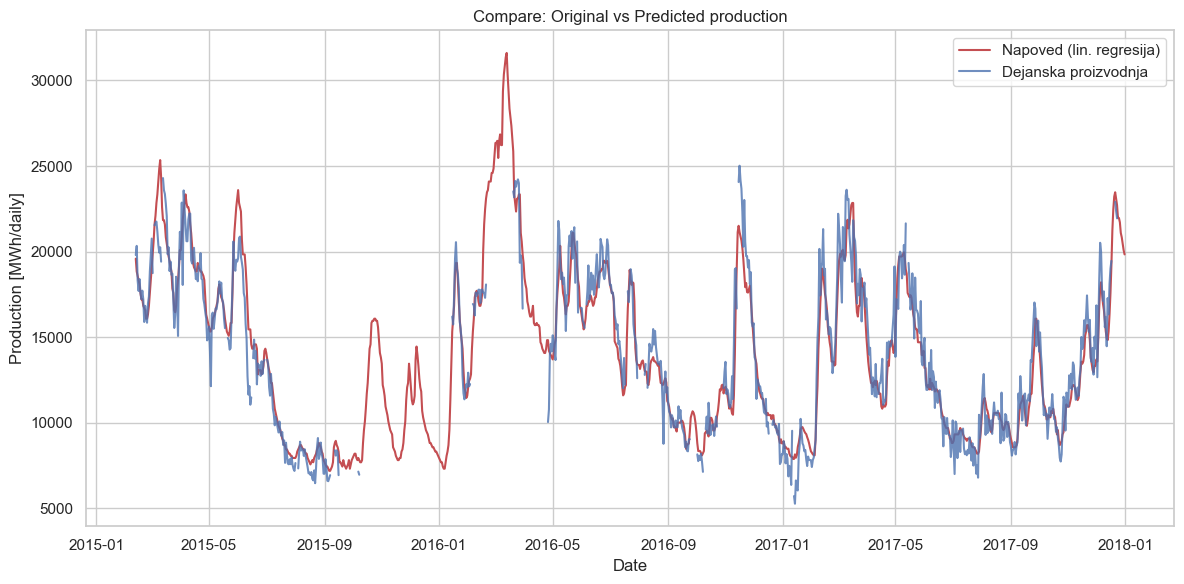

RMSE: 1335.71
MSE: 1784108.0786
R²: 0.9134


model: f(x) = 2.5043 * x + 1807.3495


In [19]:
_, model = linear_regression(df.dropna(axis=0, how='any'),
                  lr=0.006049364701993311,
                  l2=0.002332274065496888,
                  scheduler_factor=0.9035546250122138,
                  scheduler_patience=46,
                  early_stopping_patience=86,
                  min_delta=1.795957443658383e-08,
                  scaler_type="minmax",
                  epochs=5000,
                  beta1=0.952566223416211,
                  beta2=0.9203191138148997,
                  plot=True,
                  model=LinReg,)
print(_.T)
print(f"r2: {_.r2}")
print(f"mse: {_.mse}")
print(f"rmse: {_.rmse}")
print("")
w = model.w.item()
b = model.b.item()

w_original = w * (_.max_y.item() - _.min_y.item()) / (_.max_x.item() - _.min_x.item())
b_original = b * (_.max_y.item() - _.min_y.item()) + _.min_y.item() - w * (_.max_y.item() - _.min_y.item()) * _.min_x.item() / (_.max_x.item() - _.min_x.item())

df_plot = df[["Production [MWh/daily]", "River Flow [m^3/s]"]].copy()
df_plot["Prediction"] = w_original * df_plot["River Flow [m^3/s]"] + b_original
df_plot["Date"] = df_plot.index  # indeks pretvori v stolpec

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="Date", y="Prediction", label="Napoved (lin. regresija)", color="r")
plt.plot(df_plot["Date"], df_plot["Production [MWh/daily]"], label="Dejanska proizvodnja", alpha=0.8, color="b")

plt.title("Compare: Original vs Predicted production")
plt.xlabel("Date")
plt.ylabel("Production [MWh/daily]")
plt.legend()
plt.tight_layout()
plt.show()

mask = df_plot["Production [MWh/daily]"].notna() & df_plot["Prediction"].notna()

y_true = df_plot.loc[mask, "Production [MWh/daily]"]
y_pred = df_plot.loc[mask, "Prediction"]

mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")
print(f"MSE: {mse:.4f}")
print(f"R²: {r2:.4f}")

print("")
print("")

print(f"model: f(x) = {w_original:.4f} * x + {b_original:.4f}")


### Sklearn Linear regression

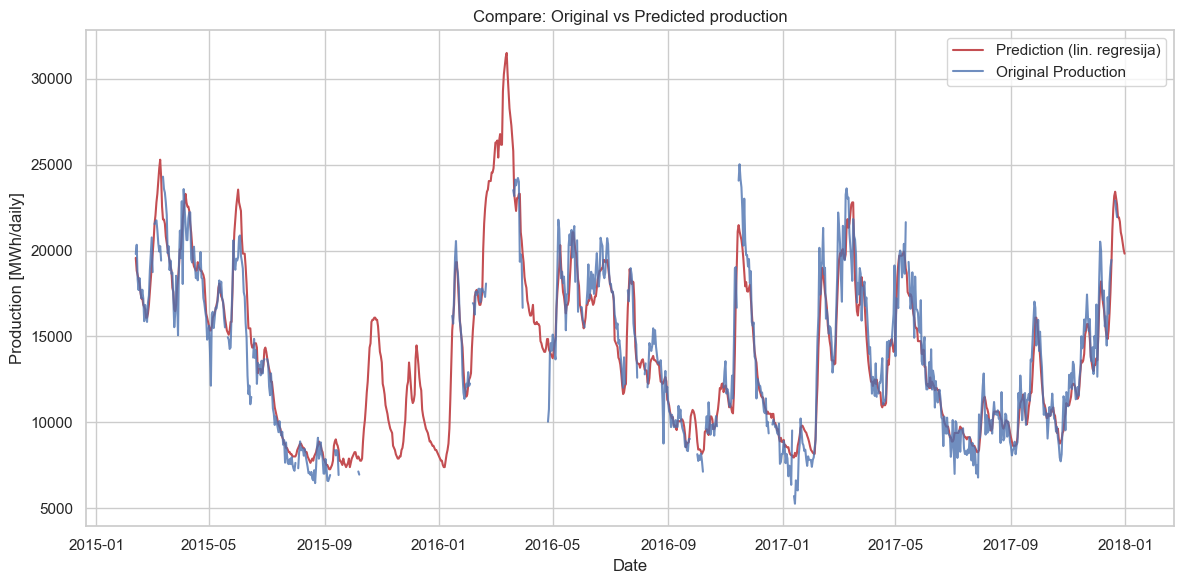

RMSE: 1334.91
MSE: 1781982.86
R²: 0.9135
model: y = 2.4841 * x + 1935.0854


In [20]:
from sklearn.linear_model import LinearRegression

df_clean = df.dropna()
X = df_clean[["River Flow [m^3/s]"]].values
y = df_clean["Production [MWh/daily]"].values

model_sc_kit = LinearRegression()
model_sc_kit.fit(X, y)

y_pred = model_sc_kit.predict(X)

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)


df_plot = df[["Production [MWh/daily]", "River Flow [m^3/s]"]].copy()
df_plot["Prediction"] = model_sc_kit.coef_[0] * df_plot["River Flow [m^3/s]"] + model_sc_kit.intercept_
df_plot["Date"] = df_plot.index  # indeks pretvori v stolpec

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="Date", y="Prediction", label="Prediction (lin. regresija)", color="r")
plt.plot(df_plot["Date"], df_plot["Production [MWh/daily]"], label="Original Production", alpha=0.8, color="b")

plt.title("Compare: Original vs Predicted production")
plt.xlabel("Date")
plt.ylabel("Production [MWh/daily]")
plt.legend()
plt.tight_layout()
plt.show()


print(f"RMSE: {rmse:.2f}")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.4f}")
print(f"model: y = {model_sc_kit.coef_[0]:.4f} * x + {model_sc_kit.intercept_:.4f}")

### So based on results Sklearn Lin. Regression was slightly better so we will use it

### Model is

#### y = 2.4841 * x + 1935.0854

#### Based on your model determine what will be daily energy production at river inflow of 4000 [m3/s]and 11000 [m3/s]?

In [21]:
inflow_values = np.array([[4000], [11000]])
predictions = model_sc_kit.predict(inflow_values)

print(f"Production [MWh/daily] with river inflow of 4000 [m3/s] would be {predictions[0]:.2f}")
print(f"Production [MWh/daily] with river inflow of 11000 [m3/s] would be {predictions[1]:.2f}")


Production [MWh/daily] with river inflow of 4000 [m3/s] would be 11871.36
Production [MWh/daily] with river inflow of 11000 [m3/s] would be 29259.83


#### b) Can you develop a non-linear model that would better describe the relationship between river flow and energy production?

##### Yes, we can develop a non-linear model (e.g., polynomial regression or neural network) that slightly improves performance. However, the improvement in accuracy is minimal compared to the increased model complexity. Given the current features, the linear model already captures the relationship well, and more complex models do not provide significant gains in predictive power. Thus, the linear model remains the most efficient and interpretable choice for this problem.

Below you can see few attempts to make better predictions

In [62]:
class SimpleNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.LayerNorm(64),
            nn.Tanh(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.Tanh(),
            nn.Dropout(dropout_rate),

            nn.Linear(32, 16),
            nn.LayerNorm(16),
            nn.Tanh(),
            nn.Dropout(dropout_rate),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.net(x)

In [63]:
def train_nn(
    df,
    model_class,
    lr=0.001,
    l2=1e-4,
    epochs=5000,
    scheduler_factor=0.5,
    scheduler_patience=15,
    early_stopping_patience=30,
    min_delta=1e-5,
    scaler_type="minmax",
    beta1=0.9,
    beta2=0.999,
    plot=True,
    dropout_rate=0.3  # NOV PARAMETER
):
    df = df.dropna().copy()
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)

    # podatki
    X = df[["River Flow [m^3/s]"]].values.astype(np.float32)
    y = df["Production [MWh/daily]"].values.astype(np.float32).reshape(-1, 1)

    # skaliranje
    if scaler_type == "minmax":
        scaler_x = MinMaxScaler()
        scaler_y = MinMaxScaler()
    else:
        scaler_x = StandardScaler()
        scaler_y = StandardScaler()

    X_scaled = scaler_x.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y)

    # razdelitev
    split_idx = int(len(y) * 0.8)
    X_train = torch.tensor(X_scaled[:split_idx])
    y_train = torch.tensor(y_scaled[:split_idx])
    X_test = torch.tensor(X_scaled[split_idx:])
    y_test = torch.tensor(y_scaled[split_idx:])

    model = model_class(dropout_rate=dropout_rate)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2, betas=(beta1, beta2))
    loss_fn = nn.MSELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=scheduler_factor, patience=scheduler_patience, min_lr=1e-9)

    best_val_loss = float('inf')
    es_counter = 0
    best_state = None
    losses, lrs = [], []

    for epoch in range(epochs):
        model.train()
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lrs.append(optimizer.param_groups[0]["lr"])

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test)
            val_loss = loss_fn(val_pred, y_test).item()

        if val_loss + min_delta < best_val_loss:
            best_val_loss = val_loss
            best_state = model.state_dict()
            es_counter = 0
        else:
            es_counter += 1
            if es_counter >= early_stopping_patience:
                break

        scheduler.step(val_loss)

    if best_state:
        model.load_state_dict(best_state)

    # evaluate
    model.eval()
    with torch.no_grad():
        y_hat = model(X_test).numpy()
        y_true = y_test.numpy()

    y_hat = scaler_y.inverse_transform(y_hat)
    y_true = scaler_y.inverse_transform(y_true)

    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_hat)

    if plot:
        plt.figure(figsize=(14, 6))
        plt.plot(y_true, label="True")
        plt.plot(y_hat, label="Prediction", linestyle="--")
        plt.title("Primerjava: True vs Predicted (SimpleNN)")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "model": model,
        "mse": mse,
        "rmse": rmse,
        "r2": r2,
        "scaler_x": scaler_x,
        "scaler_y": scaler_y,
    } , model

In [64]:
def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    l2 = trial.suggest_float("l2", 1e-8, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    beta1 = trial.suggest_float("beta1", 0.85, 0.95)
    beta2 = trial.suggest_float("beta2", 0.98, 0.9999)
    scheduler_factor = trial.suggest_float("scheduler_factor", 0.1, 0.9)
    scheduler_patience = trial.suggest_int("scheduler_patience", 5, 30)
    early_stopping_patience = trial.suggest_int("early_stopping_patience", 10, 50)
    min_delta = trial.suggest_float("min_delta", 1e-6, 1e-3, log=True)
    scaler_type = trial.suggest_categorical("scaler_type", ["minmax", "standard"])

    result, _ = train_nn(
        df=df,
        model_class=SimpleNN,
        lr=lr,
        l2=l2,
        epochs=5000,
        scheduler_factor=scheduler_factor,
        scheduler_patience=scheduler_patience,
        early_stopping_patience=early_stopping_patience,
        min_delta=min_delta,
        scaler_type=scaler_type,
        beta1=beta1,
        beta2=beta2,
        plot=False,
        dropout_rate=dropout_rate,
    )

    return result["mse"], -result["r2"]

study = optuna.create_study(directions=["minimize", "maximize"])
study.optimize(objective, n_trials=300)

best = min(study.best_trials, key=lambda t: t.values[0])
print("Najboljši parametri:")
print(best.params)
print(f"MSE: {best.values[0]:.4f}, R²: {-best.values[1]:.4f}")

[I 2025-04-13 16:48:21,309] A new study created in memory with name: no-name-ebc5bf44-579a-47ae-88b6-dec7074acde6
[I 2025-04-13 16:48:21,539] Trial 0 finished with values: [916929.375, -0.9169159531593323] and parameters: {'lr': 0.0013914931221416919, 'l2': 0.000838761460167326, 'dropout_rate': 0.04982353330755607, 'beta1': 0.8654730329735406, 'beta2': 0.9851496017459588, 'scheduler_factor': 0.1453644154684394, 'scheduler_patience': 20, 'early_stopping_patience': 32, 'min_delta': 4.56350865254467e-05, 'scaler_type': 'standard'}.
[I 2025-04-13 16:48:21,654] Trial 1 finished with values: [995221.4375, -0.9098218679428101] and parameters: {'lr': 0.004172145794210186, 'l2': 1.155858326387084e-07, 'dropout_rate': 0.03236128760560064, 'beta1': 0.8625517392520882, 'beta2': 0.9900850470897584, 'scheduler_factor': 0.6025300831423187, 'scheduler_patience': 5, 'early_stopping_patience': 27, 'min_delta': 2.4183092210507474e-05, 'scaler_type': 'minmax'}.
[I 2025-04-13 16:48:22,804] Trial 2 finished

Najboljši parametri:
{'lr': 0.00046915266351990175, 'l2': 1.1595279976478655e-06, 'dropout_rate': 0.15855059774800034, 'beta1': 0.8612941426308064, 'beta2': 0.9877325543602042, 'scheduler_factor': 0.7244958188662586, 'scheduler_patience': 14, 'early_stopping_patience': 43, 'min_delta': 2.8311306806502378e-05, 'scaler_type': 'minmax'}
MSE: 852035.3125, R²: 0.9228


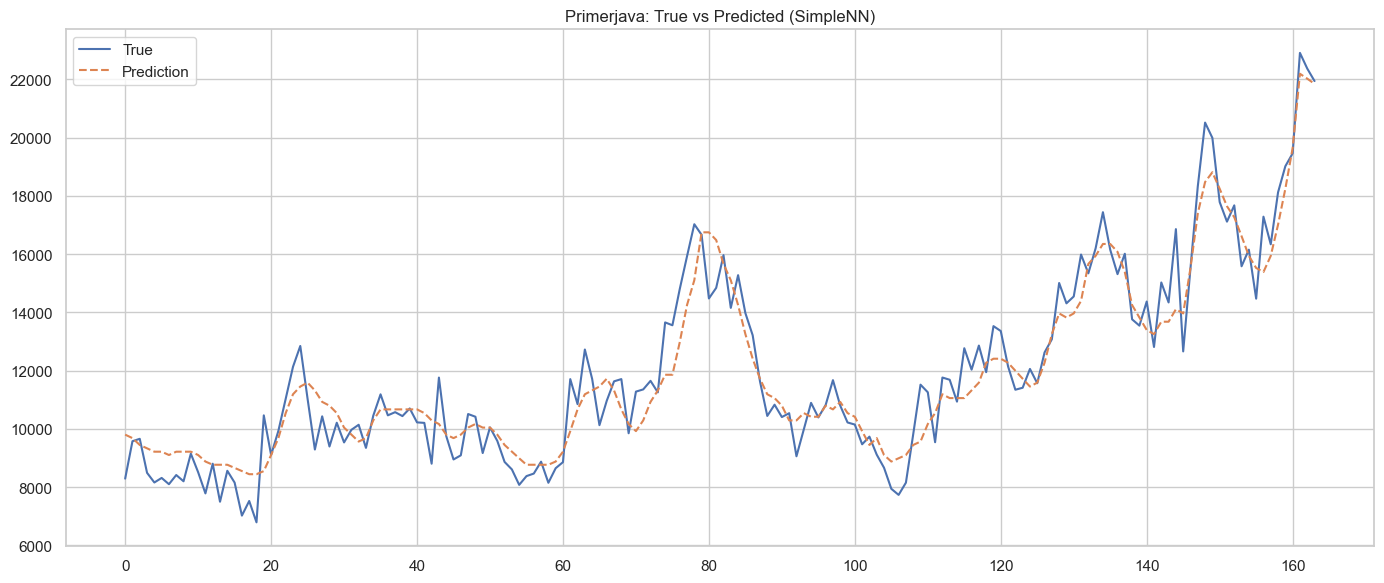

MSE: 852035.3125
RMSE: 923.0576
R²: 0.9228


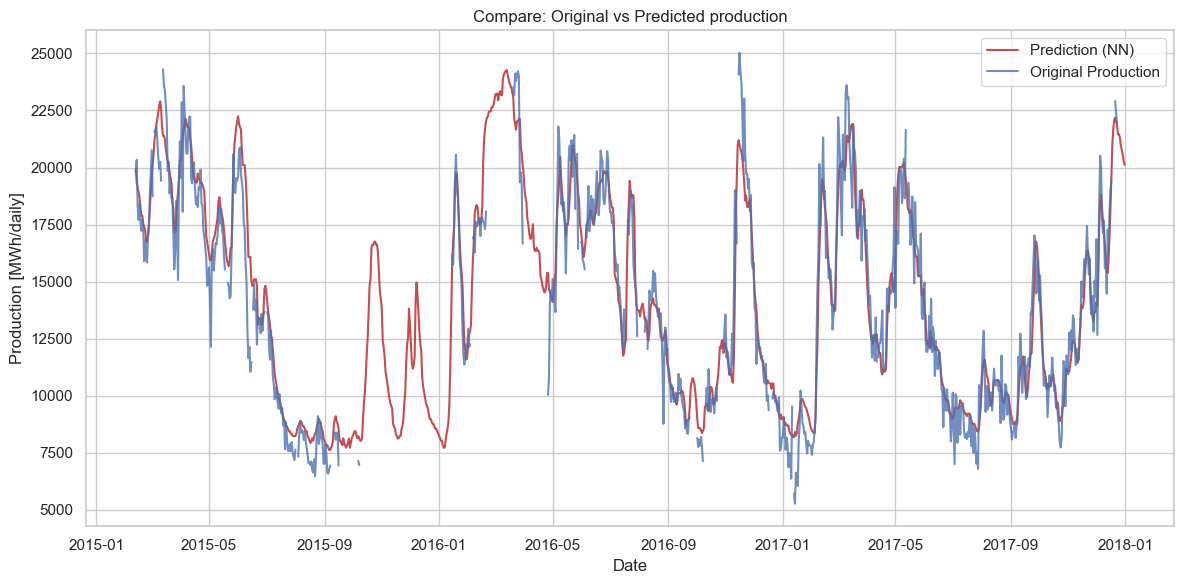

In [80]:
result, model = train_nn(
    df=df,
    model_class=SimpleNN,
    lr=0.00046915266351990175,
    l2=1.1595279976478655e-06,
    dropout_rate=0.15855059774800034,
    beta1=0.8612941426308064,
    beta2=0.9877325543602042,
    scheduler_factor=0.7244958188662586,
    scheduler_patience=14,
    early_stopping_patience=43,
    min_delta=2.8311306806502378e-05,
    scaler_type="minmax",
    epochs=5000,
    plot=True,
)

print(f"MSE: {result['mse']:.4f}")
print(f"RMSE: {result['rmse']:.4f}")
print(f"R²: {result['r2']:.4f}")

df_plot = df[["Production [MWh/daily]", "River Flow [m^3/s]"]].copy()
X = df_plot[["River Flow [m^3/s]"]].values.astype(np.float32)
X_scaled = result["scaler_x"].transform(X)

with torch.no_grad():
    y_pred_scaled = model(torch.tensor(X_scaled)).numpy()
    y_pred = result["scaler_y"].inverse_transform(y_pred_scaled)

df_plot["Prediction"] = y_pred
df_plot["Date"] = df_plot.index

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="Date", y="Prediction", label="Prediction (NN)", color="r")
plt.plot(df_plot["Date"], df_plot["Production [MWh/daily]"], label="Original Production", alpha=0.8, color="b")

plt.title("Compare: Original vs Predicted production")
plt.xlabel("Date")
plt.ylabel("Production [MWh/daily]")
plt.legend()
plt.tight_layout()
plt.show()

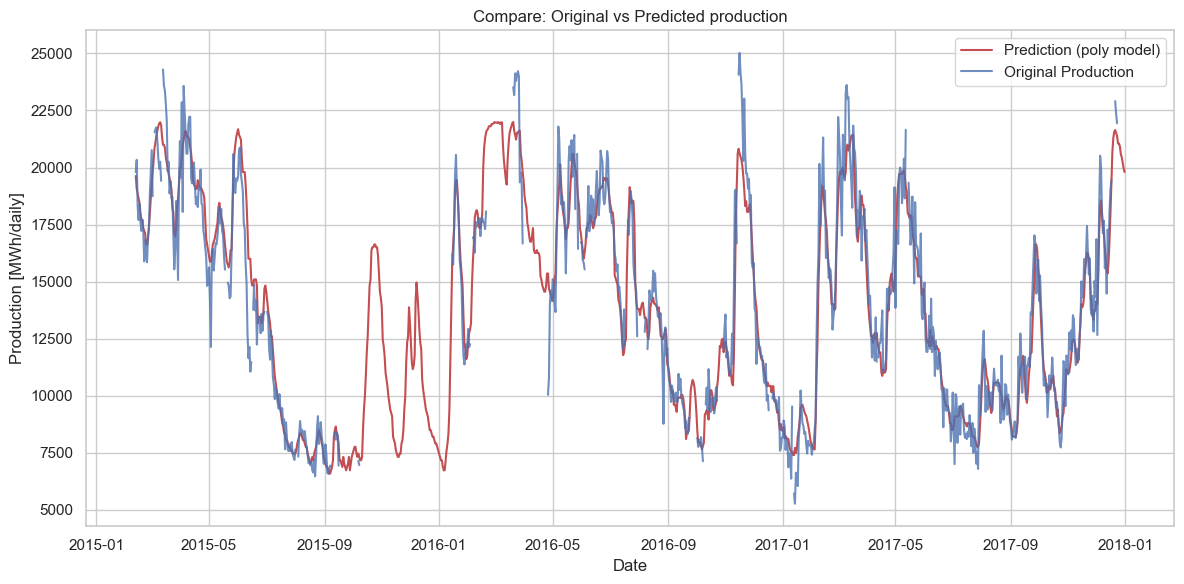

Best poly: rank 3
Formula: y = 763.0834 + 0.0000 * x^0 + 2.3879 * x^1 + 0.0002 * x^2 + -0.0000 * x^3
R²: 0.9266


In [79]:
df_clean = df.dropna()
X = df_clean[["River Flow [m^3/s]"]].values
y = df_clean["Production [MWh/daily]"].values

best_r2 = -float("inf")
best_deg = None
best_model = None

for deg in range(1, 10):
    model = make_pipeline(PolynomialFeatures(degree=deg), LinearRegression())
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    if r2 > best_r2:
        best_r2 = r2
        best_deg = deg
        best_model = model

poly = best_model.named_steps["polynomialfeatures"]
lin = best_model.named_steps["linearregression"]
coefs = lin.coef_.flatten()
intercept = lin.intercept_

# priprava za graf
df_plot = df[["Production [MWh/daily]", "River Flow [m^3/s]"]].copy()
X_all = df_plot[["River Flow [m^3/s]"]].values
df_plot["Prediction"] = best_model.predict(X_all)
df_plot["Date"] = df_plot.index

# graf
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot, x="Date", y="Prediction", label="Prediction (poly model)", color="r")
plt.plot(df_plot["Date"], df_plot["Production [MWh/daily]"], label="Original Production", alpha=0.8, color="b")

plt.title("Compare: Original vs Predicted production")
plt.xlabel("Date")
plt.ylabel("Production [MWh/daily]")
plt.legend()
plt.tight_layout()
plt.show()

terms = [f"{coefs[i]:.4f} * x^{i}" for i in range(len(coefs))]
formula = " + ".join(terms)
print(f"Best poly: rank {best_deg}")
print(f"Formula: y = {intercept:.4f} + {formula}")
print(f"R²: {best_r2:.4f}")

#### c) Hydro production model has now been built on historical data of measured/realized river flow. Think about a daily forecasting process, what would an analyst need to forecast daily energy production for a few days ahead? Which data would be needed and how would you get it? Present your idea in a short paragraph.

To forecast daily energy production for a few days ahead, an analyst would need reliable short-term forecasts of river flow, which depend heavily on weather conditions. Therefore, access to meteorological data (e.g., from local weather stations or numerical weather prediction models) such as precipitation, temperature, and snowmelt forecasts would be essential. The analyst could either build a model to predict river flow based on this data or directly use existing hydrological forecasts. Additionally, using more extensive historical time series data would allow for the development of autoregressive or sequence-based models (e.g., RNN, LSTM) that can capture temporal dependencies. Combining these approaches would enable more accurate and robust short-term predictions of hydro energy production.

#### d) There are various factors that affect electricity prices on wholesale exchanges. Apart of hydro production, what are, in your opinion, those factors that are influencing electricity prices on a daily basis? Do you expect any significant changes on electricity markets in the following years?

Several factors influence electricity prices on wholesale markets. Besides hydro production, key drivers include demand levels (which depend on temperature, season, and economic activity), availability and costs of other energy sources (e.g., gas, coal, nuclear, renewables), fuel prices, CO₂ emission allowance prices, grid constraints, and cross-border energy flows. Market dynamics are also affected by policy and regulatory changes. In the coming years, significant changes are expected due to the growing integration of renewable energy sources (solar, wind), increased electrification (e.g., EVs), decentralization (e.g., prosumers), and advancements in energy storage. These trends are likely to make electricity markets more volatile but also more flexible and responsive.